<a href="https://colab.research.google.com/github/1991ta/hello/blob/master/thesis01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turning Point Detection

# 1.**Introduction**
* **popular features in turning point detection**

1. **Historical Price Data**: Open, high, low, close prices, and volume traded.
2. **Technical Indicators**: Moving averages, RSI, MACD, Bollinger Bands, etc.
3. **Market Sentiment**: Sentiment analysis of news and social media.
4. **Lagged Features**: Historical behavior of the stock.
5. **Volatility Measures**: Historical and implied volatility.
6. **Fundamental Analysis**: EPS, P/E ratio, debt-to-equity ratio, etc.
7. **Market-wide Indicators**: Interest rates, GDP growth, etc.
8. **Seasonality and Calendar Effects**: Day-of-week, month-of-year effects, etc.
9. **External Factors**: Regulatory changes, technological advancements, etc.
10. **Customized Features**: Domain-specific engineered features.

These features are pre-processed before feeding into neural networks, including normalization, scaling, and dimensionality reduction. Features chosen depend on analysis objectives and dataset characteristics.

*   **categorizing Technical Indicators**

This table provides a concise overview of different types of technical indicators used in financial market analysis, along with examples and brief descriptions of their functionalities.

| Type of Indicator         | Examples                                                | Description                                                                                                           |
|---------------------------|---------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| Trend Following Indicators | Moving Averages (MA), MACD (Moving Average Convergence Divergence) | Identify trend direction and potential reversals when the price crosses certain lines.                                 |
| Oscillators               | Relative Strength Index (RSI), Stochastic Oscillator    | Detect overbought/oversold conditions and potential turning points based on price momentum.                           |
| Volume-Based Indicators   | On-Balance Volume (OBV), Chaikin Money Flow (CMF)       | Measure buying and selling pressure using volume data to confirm price movements.                                      |
| Volatility Indicators      | Bollinger Bands, Average True Range (ATR)               | Assess market volatility levels and identify potential turning points based on price range.                            |
| Momentum Indicators       | Momentum, Rate of Change (ROC)                          | Measure the strength of price movements and identify potential reversals based on rate of change.                      |


Each type of indicator has its strengths and weaknesses, such as trend followers being good for identifying trends but lagging during turning points, oscillators spotting overbought/oversold conditions but sometimes giving false signals, volume-based indicators confirming price movements but not always leading price changes, volatility indicators assessing market volatility but not providing directional signals, and momentum indicators indicating price strength but not pinpointing exact turning points.

Combining multiple indicators from different categories can provide a more comprehensive analysis and improve the accuracy of turning point detection in financial markets. Traders often customize their indicator setups based on their trading strategies and risk tolerance.

# 2.**Import Data**



## install

In [70]:
!pip install twelvedata
!pip install --upgrade mplfinance


## importing Packages

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from twelvedata import TDClient
import pandas as pd
import mplfinance as mpf
from sklearn.preprocessing import OneHotEncoder


## symbol specification

In [32]:
# symbol
symbol = "AAPL"
interval = "1day"
outputsize = 40
Exchange="Binance"
start_date="2010-12-16T00:00:00"
end_date="2022-12-19T00:00:00"
timezone = "Exchange"


## API key

In [10]:
# Define the API key for the Twelve Data client (replace with your actual API key)
TD_API_KEY = "your API key"

# Initialize the Twelve Data client outside the functions for efficiency
td_client = TDClient(apikey=TD_API_KEY)


## fetch time series from 12data

In [29]:
def fetch_data(symbol: str, interval: str, outputsize: int, start_date=None, end_date=None, timezone=None) -> pd.DataFrame:
    """
    Fetch financial time series data from Twelve Data API.

    Parameters:
        symbol (str): Symbol of the asset (stock ticker (e.g. AAPL, MSFT);
                                           physical currency pair (e.g. EUR/USD, CNY/JPY);
                                           digital currency pair (BTC/USD, XRP/ETH)).
        interval (str): Interval of the time series (e.g., '1min', '1day', etc.).
        outputsize (int): Output size of the time series (e.g., 'compact' or 'full').
    Returns:
        pd.DataFrame: Pandas DataFrame containing the fetched time series data sorted by datetime.
    """
    try:
        # Check if the optional arguments are provided
        optional_args = {}
        if start_date is not None:
            optional_args['start_date'] = start_date
        if end_date is not None:
            optional_args['end_date'] = end_date
        if timezone is not None:
            optional_args['timezone'] = timezone

        # Fetch the time series data using the Twelve Data client as a panda dataframe
        ts = td_client.time_series(
            symbol=symbol,
            outputsize=outputsize,
            interval=interval,
            order='asc',  # Sort the time series data by datetime for consistency
            **optional_args  # Pass optional arguments dynamically
        )

        return ts
    except Exception as e:
        # Handle any errors that may occur during data fetching
        print(f"Error fetching data: {e}")
        return None


In [71]:
# Call the fetch_data function with keyword arguments
ts = fetch_data(symbol=symbol, interval=interval, outputsize=outputsize, start_date=start_date, end_date=end_date, timezone=timezone).as_pandas()
ts.head()

,open,high,low,close,volume
datetime,,,,,
2022-10-21,142.87000,147.85001,142.64999,147.27000,86548600
2022-10-24,147.19000,150.23000,146.00000,149.45000,75981900
2022-10-25,150.09000,152.49001,149.36000,152.34000,74732300
2022-10-26,150.96001,151.99001,148.03999,149.35001,88194300
2022-10-27,148.07001,149.05000,144.13000,144.80000,109180200


### plot time series








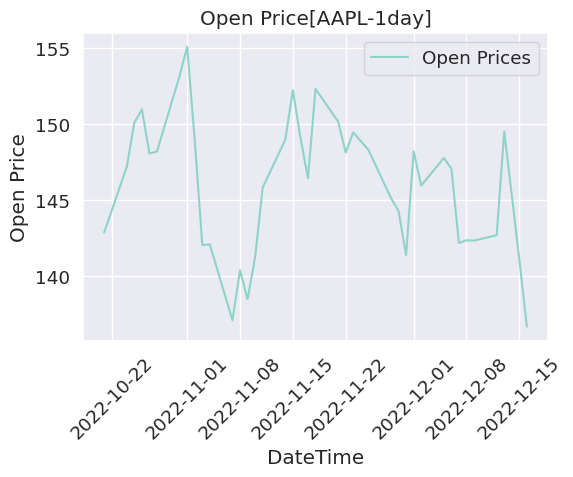

In [122]:
# Set the style and context for Seaborn plots
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)

# Plot the "open" prices using Seaborn's lineplot
plt.figure(figsize=(6, 4))
sns.lineplot(data=ts[0:200], x=ts[0:200].index, y='open', label='Open Prices')

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Open Price')
plt.title('Open Price['+symbol+'-'+interval+']')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Show the plot
plt.legend()
plt.show()

### plot candles
mpl finance package

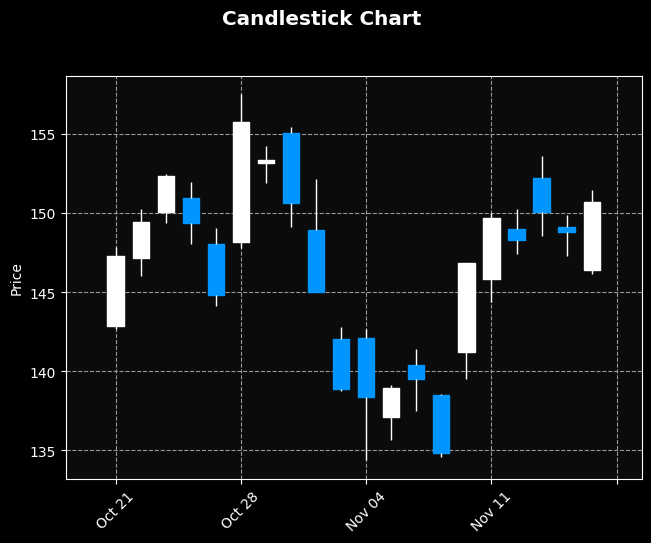

In [124]:

# Plot candlestick chart using mplfinance with default style
mpf.plot(ts[0:20], type='candle', title='Candlestick Chart', ylabel='Price', style='nightclouds')

# Show the plot
plt.show()


## fetch Technical Indicators from 12data

In [125]:
# Define a function to fetch technical indicators from Twelve Data API
def fetch_technical_indicators(symbol: str, interval: str, outputsize: int, start_date=None, end_date=None, timezone=None) -> pd.DataFrame:
    """
    Fetch technical indicators from Twelve Data API.

    Parameters:
        symbol (str): Symbol of the asset (stock ticker, physical currency pair, digital currency pair).
        interval (str): Interval of the time series (e.g., '1min', '1day', etc.).
        outputsize (int): Output size of the time series (e.g., 'compact' or 'full').
        start_date (str): Start date and time of the sampling period (optional).
        end_date (str): End date and time of the sampling period (optional).
        timezone (str): Timezone at which output datetime will be displayed (optional).

    Returns:
        pd.DataFrame: Pandas DataFrame containing the fetched technical indicators.
            Columns: ['Williams %R (time_period=12)', 'Relative Strength Index (RSI) (time_period=6)',
                      'RSI (time_period=12)', 'Moving Average (MA) (time_period=5)', 'MA (time_period=6)',
                      'MA (time_period=10)', 'MA (time_period=20)', 'Volume Weighted Average Price (VWAP)']
    """
    # Fetch the financial time series data using the fetch_data function
    ts = fetch_data(symbol, interval, outputsize, start_date, end_date, timezone)

    # Check if data fetching was successful
    if ts is None:
        return None

    try:
        # Calculate various technical indicators using Twelve Data API methods
        df_with_TI = ts.with_willr(time_period=12)\
        .with_rsi(time_period=6)\
        .with_rsi(time_period=12)\
        .with_ma(time_period=5)\
        .with_ma(time_period=6)\
        .with_ma(time_period=20)\
        .with_ma(time_period=50)\
        .with_vwap()\
        .with_stoch()\
        .with_bbands(ma_type="EMA")\
        .as_pandas()

        # Define a dictionary mapping old names to new names
        new_names = {
            'rsi1': 'rsi6',
            'rsi2': 'rsi12',
            'ma1': 'ma5',
            'ma2': 'ma6',
            'ma3': 'ma20',
            'ma4': 'ma50'
        }

        # Rename the columns using the rename method
        df_with_TI.rename(columns=new_names, inplace=True)


        # Return the calculated technical indicators as a pandas DataFrame
        return df_with_TI
    except Exception as e:
        # Handle any errors that may occur during technical indicator calculation
        print(f"Error fetching technical indicators: {e}")
        return None


In [154]:
# fetching Data From TwelveData
df = fetch_technical_indicators(symbol, interval, outputsize, start_date, end_date, timezone)

In [155]:
df.head(3)

,open,high,low,close,volume,willr,rsi6,rsi12,ma5,ma6,ma20,ma50,vwap,slow_k,slow_d,upper_band,middle_band,lower_band
datetime,,,,,,,,,,,,,,,,,,
2022-10-21,142.87,147.85001,142.64999,147.27,86548600,-4.30268,65.79060,53.10872,144.136,143.17667,143.6655,154.107,145.92333,95.69732,78.74804,152.15307,144.15174,136.15041
2022-10-24,147.19,150.23000,146.00000,149.45,75981900,-4.91802,71.18317,56.59240,145.544,145.02167,143.5995,153.654,148.56000,95.08198,86.42278,152.44101,144.65633,136.87166
2022-10-25,150.09,152.49001,149.36000,152.34,74732300,-0.82786,76.96072,60.80375,147.262,146.67667,143.6285,153.237,151.39667,99.17214,96.65048,153.29749,145.38811,137.47873


# 3.**Data Preprocessing**

## **Introduction to TI and trading rules**



*   **categorizing different types of technical indicators (TIs)**

| Type of TI             | Examples                      | Units             | Boundaries/Ranges   | Trading Rule                                                                                         |
|------------------------|-------------------------------|--------------------|---------------------|------------------------------------------------------------------------------------------------------|
| Trend Following        | Moving Averages (MA)          | Price (e.g., USD)  | Price crosses MA    | Buy when price crosses above MA (uptrend), sell when price crosses below MA (downtrend)              |
|                        | MACD (Moving Average Convergence Divergence) | Difference (no unit) | Crossovers (e.g., MACD line crossing signal line) | Buy when MACD line crosses above signal line, sell when MACD line crosses below signal line           |
|                        | Parabolic SAR                 | Price (e.g., USD)  | Reversal points     | Buy when SAR below price (uptrend), sell when SAR above price (downtrend)                             |
| Oscillators            | Relative Strength Index (RSI) | Unitless (0-100)   | Overbought (70+), Oversold (30-) | Buy when RSI crosses above 30 from below (bullish), sell when RSI crosses below 70 from above (bearish) |
|                        | Stochastic Oscillator         | Unitless (0-100)   | Overbought (80+), Oversold (20-) | Buy when %K crosses above %D below 20 (bullish), sell when %K crosses below %D above 80 (bearish)    |
|                        | Commodity Channel Index (CCI) | Unitless           | Overbought (100+), Oversold (-100-) | Buy when CCI crosses above -100 (uptrend), sell when CCI crosses below 100 (downtrend)               |
| Volume-Based           | On-Balance Volume (OBV)       | Volume             | No specific boundary | Buy when OBV confirms price uptrend, sell when OBV confirms price downtrend                             |
|                        | Chaikin Money Flow (CMF)      | Unitless           | Above 0 (buying pressure), Below 0 (selling pressure) | Buy when CMF crosses above 0 (uptrend), sell when CMF crosses below 0 (downtrend)                     |
|                        | Volume Weighted Average Price (VWAP) | Price x Volume   | No specific boundary | Buy when price above VWAP (uptrend), sell when price below VWAP (downtrend)                            |
| Volatility             | Bollinger Bands               | Price (e.g., USD)  | Price bands         | Buy when price touches lower band (oversold), sell when price touches upper band (overbought)         |
|                        | Average True Range (ATR)      | Price (e.g., USD)  | Volatility levels   | Buy/sell based on ATR changes (high ATR may indicate volatility and potential reversals)              |
|                        | Volatility Index (VIX)        | Percentage         | No specific boundary | Buy when VIX low (market complacency), sell when VIX high (market fear or uncertainty)               |
| Momentum               | Momentum                      | Price (e.g., USD)  | Momentum values     | Buy when momentum turns positive (upward trend), sell when momentum turns negative (downward trend)   |
|                        | Rate of Change (ROC)          | Percentage         | Positive/Negative   | Buy when ROC crosses above 0 (uptrend), sell when ROC crosses below 0 (downtrend)                     |
|                        | Relative Momentum Index (RMI) | Unitless           | Overbought (70+), Oversold (30-) | Buy when RMI crosses above 30 (uptrend), sell when RMI crosses below 70 (downtrend)                  |

The trading rules provided are general guidelines and may need to be adjusted based on market conditions, asset type, and individual trading strategies. Traders often combine multiple indicators and use additional analysis to confirm signals before making trading decisions.
Encoding Categorical variables
Categorical variables in machine learning models require special treatment

*   **Encoding Categorical variables**


compared to numerical variables because they represent discrete categories rather than continuous values. Here's how you can handle categorical variables in ML models:
Here's the information structured into a table format for easier reference:

| Encoding Method       | Description                                                                               | Example                     |
|-----------------------|-------------------------------------------------------------------------------------------|-----------------------------|
| Label Encoding        | Converts binary categorical variables into numerical values (0 and 1).                    | "Gender" (Male, Female)     |
| One-Hot Encoding      | Creates binary columns for each category, indicating presence (1) or absence (0).          | "Color" (Red, Green, Blue)  |
| Dummy Variables       | Similar to one-hot encoding, creates binary columns directly in some frameworks.          | "Color" (Red, Green, Blue)  |
| Ordinal Encoding      | Assigns numerical values based on the order of categories for variables with order.       | "Education_Level" (High School, Bachelor's, Master's, Ph.D.) |
| Target Encoding       | Replaces categories with the mean of the target variable for each category.                | "City" (Average housing prices per city) |
| Frequency Encoding    | Replaces categories with the frequency of occurrences in the dataset.                     | "Country" (Number of users per country)    |

These encoding methods are commonly used for handling categorical variables in machine learning models, and the choice depends on the specific characteristics of your data and the ML algorithm you're using.

## **Feature Engineering**

## **RSI(Oscillator)**
The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. It is used in technical analysis to identify overbought or oversold conditions in an asset's price.

Here's how the RSI works and how traders use it to trade:

1. **Calculation of RSI:** The RSI is calculated using a formula that takes into account the average gain and average loss over a specified period. The formula is typically calculated over a 14-day period but can be adjusted based on trader preferences.

   RSI = 100 - (100 / (1 + RS))
   - RS (Relative Strength) = Average Gain / Average Loss
   - Average Gain = (Sum of gains over N periods) / N
   - Average Loss = (Sum of losses over N periods) / N

2. **Interpreting RSI Levels:**
   - RSI values range from 0 to 100.
   - When the RSI is above 70, it indicates that the asset may be overbought, and a correction or reversal downward could occur. Traders may consider this a sell signal.
   - Conversely, when the RSI is below 30, it suggests that the asset may be oversold, and a bounce or reversal upward could happen. Traders may view this as a buy signal.

3. **Divergence Signals:** Traders also look for divergence between the RSI and price movements. For example:
   - Bullish Divergence: Occurs when the price makes a new low, but the RSI makes a higher low. This could signal a potential reversal upward.
   - Bearish Divergence: Occurs when the price makes a new high, but the RSI makes a lower high. This could signal a potential reversal downward.

4. **Trading Strategies Using RSI:**
   - **Overbought and Oversold Conditions:** Traders may use RSI to identify overbought and oversold conditions and look for potential reversals or corrections in price.
   - **RSI Trend Confirmation:** Traders may use RSI in conjunction with other technical indicators or chart patterns to confirm trends. For example, if the RSI is trending higher along with an uptrend in price, it may confirm the strength of the uptrend.
   - **RSI Crossovers:** Some traders use RSI crossovers of key levels (e.g., 30 and 70) as buy or sell signals. For instance, an RSI crossing above 70 could signal a sell, while an RSI crossing below 30 could signal a buy.

Overall, the RSI is a versatile tool that helps traders assess the strength and potential reversals in price movements, providing valuable insights for trading decisions.

### ***Visualization***

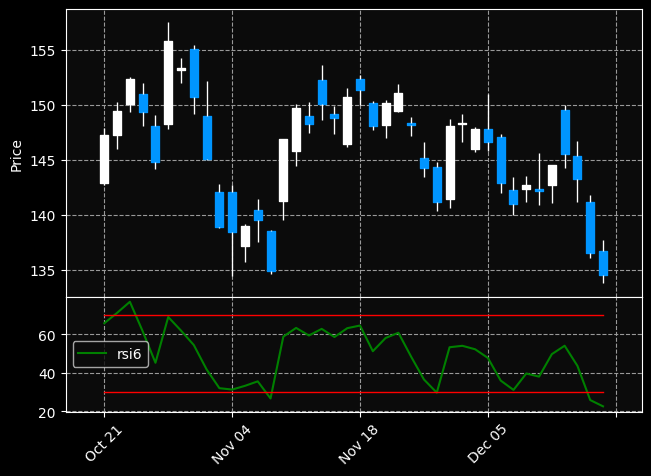

In [156]:
# Create horizontal line data for RSI thresholds
df['rsi_overbought'] = 70
df['rsi_oversold'] = 30

rsi_plot = [mpf.make_addplot(df['rsi6'], panel=1, color='g', label='rsi6' ,width=1.5),
            mpf.make_addplot(df['rsi_overbought'], panel=1, color='r', width=1),
            mpf.make_addplot(df['rsi_oversold'], panel=1, color='r', width=1)]

mpf.plot(df,volume=False,addplot=rsi_plot, type='candle', style='nightclouds',title='Preview of RSI')

### **Feature Engineering**
The following code snippet is designed to preprocess the 'rsi6' column in our DataFrame for further analysis. Here's a breakdown of each step:

 **Creating RSI Categories**:

   We first categorize the 'rsi6' column into three distinct categories using `pd.cut`. This categorization helps in simplifying the data and identifying patterns or trends within different ranges of RSI (Relative Strength Index).




In [157]:
N = 10
# Categorize the specified column into N categories
df['rsi6_category'] = pd.cut(df['rsi6'], bins=N, labels=False)
print('\n',df[['rsi6','rsi6_category']].head())


                 rsi6  rsi6_category
datetime                           
2022-10-21  65.79060              7
2022-10-24  71.18317              8
2022-10-25  76.96072              9
2022-10-26  61.62207              7
2022-10-27  45.17915              4


 **One hot encoding the categorized RSI**:

 The `encode_categorical_column`function in the provided code below performs one-hot encoding on the categorized data.


In [158]:
def encode_categorical_column(df, col_name):
    """
    Encode a categorical column in a DataFrame using one-hot encoding.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        col_name (str): Name of the column to encode.
    Returns:
        pd.DataFrame: DataFrame with the categorical column encoded using one-hot encoding.
    """
    # Perform one-hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    encoded_col = encoder.fit_transform(df[[col_name]])
    N = encoded_col.shape[1]
    # Convert the encoded array back to a DataFrame
    encoded_df = pd.DataFrame(encoded_col, columns=[f'{col_name}{i+1}' for i in range(N)], index=df.index)

    # Convert the data type of encoded_df to integer
    encoded_df = encoded_df.astype(int)

    # Concatenate the original DataFrame with the encoded DataFrame
    final_df = pd.concat([df, encoded_df], axis=1)

    return final_df



In [159]:
# One hot encoding categorized rsi column
df = encode_categorical_column(df, 'rsi6_category')
df.head(3)


,open,high,low,close,volume,willr,rsi6,rsi12,ma5,ma6,...,rsi6_category1,rsi6_category2,rsi6_category3,rsi6_category4,rsi6_category5,rsi6_category6,rsi6_category7,rsi6_category8,rsi6_category9,rsi6_category10
datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-21,142.87,147.85001,142.64999,147.27,86548600,-4.30268,65.79060,53.10872,144.136,143.17667,...,0,0,0,0,0,0,0,1,0,0
2022-10-24,147.19,150.23000,146.00000,149.45,75981900,-4.91802,71.18317,56.59240,145.544,145.02167,...,0,0,0,0,0,0,0,0,1,0
2022-10-25,150.09,152.49001,149.36000,152.34,74732300,-0.82786,76.96072,60.80375,147.262,146.67667,...,0,0,0,0,0,0,0,0,0,1


##   **MA(Trend Following)**
A moving average is a commonly used technical analysis tool in financial markets to identify trends and smooth out price fluctuations over a specified time period. It's calculated by taking the average price of a security over a set number of periods, such as days, weeks, or months.

As a trend-following indicator, moving averages help traders determine the direction of the trend and potential entry or exit points. Here's how it works:

1. **Types of Moving Averages:** There are different types of moving averages, but the two most common ones are the simple moving average (SMA) and the exponential moving average (EMA). SMA gives equal weight to each data point, while EMA assigns more weight to recent prices, making it more responsive to recent price changes.

2. **Identifying Trends:** Traders use moving averages to identify trends in the market. When the price is above the moving average, it suggests an uptrend, while a price below the moving average indicates a downtrend.

3. **Crossover Strategy:** One of the popular ways to use moving averages as a trading rule is the crossover strategy. This strategy involves two moving averages: a shorter-term moving average (e.g., 20-day SMA) and a longer-term moving average (e.g., 50-day SMA).

   - **Golden Cross:** A bullish signal occurs when the shorter-term moving average crosses above the longer-term moving average. Traders may interpret this as a buy signal, indicating a potential uptrend.
   
   - **Death Cross:** Conversely, a bearish signal occurs when the shorter-term moving average crosses below the longer-term moving average. This could be seen as a sell signal, suggesting a potential downtrend.


**Identifying Trends using MA**

In [164]:
def find_trends_using_MA(df, price_col, ma_col):
    """
    Identifying Trends: Traders use moving averages to identify trends in the market.
    When the price is above the moving average, it suggests an uptrend, while a price
    below the moving average indicates a downtrend.

    Parameters:
    df (DataFrame): The DataFrame containing price and moving average data.
    price_col (str): The column name for the price data.
    ma_col (str): The column name for the moving average data.

    Returns:
    DataFrame: The original DataFrame with an added column 'trend_ma' indicating the trend.
    """
    df['trend_ma'] = 0
    for i in range(1, len(df)):
        if df[price_col][i] > df[ma_col][i] :
            df.loc[df.index[i], 'trend_ma'] = 1  # Uptrend
        elif df[price_col][i] < df[ma_col][i] :
            df.loc[df.index[i], 'trend_ma'] = -1  # Downtrend
    return df

In [165]:
# identifying trends
df = find_trends_using_MA(df, 'close', 'ma5')

# Create new column based on 'trend'
df['adjusted_close_downtrend'] = df.apply(lambda row: row['close'] * 0.995 if row['trend_ma'] == -1 else np.nan, axis=1)
df['adjusted_close_uptrend'] = df.apply(lambda row: row['close'] * 1.005 if row['trend_ma'] == +1 else np.nan, axis=1)

df[['close','ma5','trend_ma','adjusted_close_downtrend']].head(3)


,close,ma5,trend_ma,adjusted_close_downtrend
datetime,,,,
2022-10-21,147.27,144.136,0,NaN
2022-10-24,149.45,145.544,1,NaN
2022-10-25,152.34,147.262,1,NaN


**MA Crossover Strategy**

In [166]:
def find_ma_crossovers(df, ma_short_col, ma_long_col):
    """
    Implements the crossover strategy using moving averages as a trading rule.

    Crossover Strategy:
    - Golden Cross: A bullish signal occurs when the shorter-term moving average crosses above the longer-term moving average.
      Traders may interpret this as a buy signal, indicating a potential uptrend.
    - Death Cross: A bearish signal occurs when the shorter-term moving average crosses below the longer-term moving average.
      This could be seen as a sell signal, suggesting a potential downtrend.

    Parameters:
    df (DataFrame): The DataFrame containing the shorter-term and longer-term moving average columns.
    ma_short_col (str): The column name for the shorter-term moving average.
    ma_long_col (str): The column name for the longer-term moving average.

    Returns:
    DataFrame: The original DataFrame with an added column 'signal_ma_crossover' indicating the crossover signals (1 for Golden Cross, -1 for Death Cross).
    """
    df['signal_ma_crossover'] = 0
    for i in range(1, len(df)):
        if df[ma_short_col][i] > df[ma_long_col][i] and df[ma_short_col][i - 1] <= df[ma_long_col][i - 1]:
            df.loc[df.index[i], 'signal_ma_crossover'] = 1  # when the shorter-term MA crosses above the longer-term MA, interpreted as a buy signal
        elif df[ma_short_col][i] < df[ma_long_col][i] and df[ma_short_col][i - 1] >= df[ma_long_col][i - 1]:
            df.loc[df.index[i], 'signal_ma_crossover'] = -1  # when the shorter-term MA crosses below the loner-term MA, interpreted as a buy signal
    return df

In [168]:
# identifying trends
df = find_ma_crossovers(df, 'ma20', 'ma50')

# Create new column based on 'trend'
df['adjusted_close_ma_cross_buy'] = df.apply(lambda row: row['close'] * 0.995 if row['signal_ma_crossover'] == -1 else np.nan, axis=1)
df['adjusted_close_ma_cross_sell'] = df.apply(lambda row: row['close'] * 1.005 if row['signal_ma_crossover'] == +1 else np.nan, axis=1)

# df[['close','ma5','signal_ma_crossover','adjusted_close_ma_cross_buy']].head(3)

### ***Visualization***

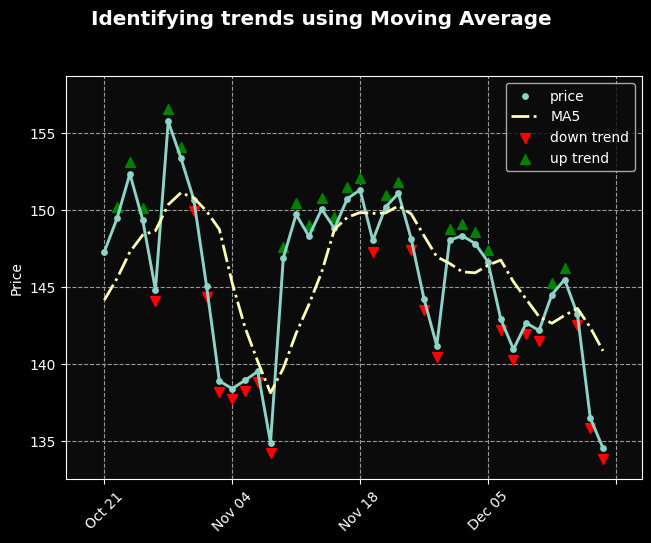

In [169]:
apds = [
        mpf.make_addplot(df['close'], type='scatter', markersize=15, marker='o', label='price'),
        mpf.make_addplot(df['ma5'], type='line', linestyle='-.', width=2, label='MA5'),
        mpf.make_addplot(df['adjusted_close_downtrend'],type='scatter',markersize=50,marker='v',color='red', label='down trend'),
        mpf.make_addplot(df['adjusted_close_uptrend'],type='scatter',markersize=50,marker='^',color='green', label='up trend')]

mpf.plot(df,type='line', style='nightclouds', addplot=apds, title='Identifying trends using Moving Average')


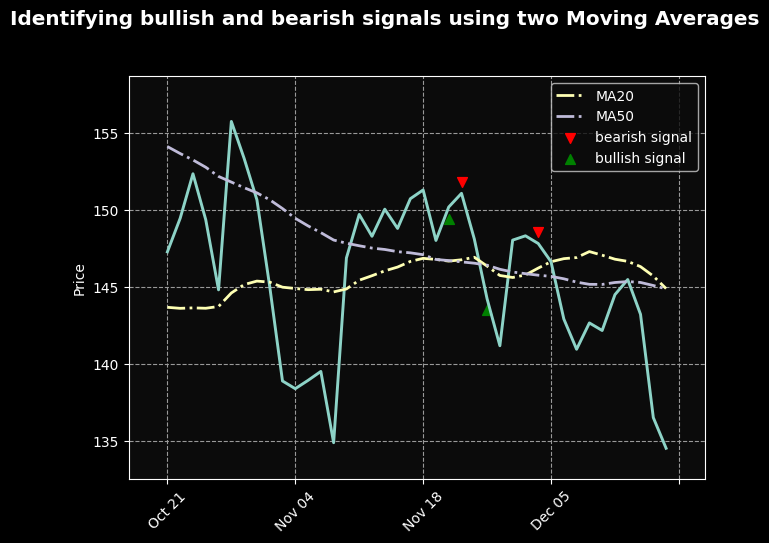

In [170]:
apds = [
        mpf.make_addplot(df['ma20'], type='line', linestyle='-.', width=2, label='MA20'),
        mpf.make_addplot(df['ma50'], type='line', linestyle='-.', width=2, label='MA50'),
        mpf.make_addplot(df['adjusted_close_ma_cross_sell'],type='scatter',markersize=50,marker='v',color='red', label='bearish signal'),
        mpf.make_addplot(df['adjusted_close_ma_cross_buy'],type='scatter',markersize=50,marker='^',color='green', label='bullish signal')]

mpf.plot(df,type='line', style='nightclouds', addplot=apds, title='Identifying bullish and bearish signals using two Moving Averages')


### ***Feature Engineering***

In [ ]:
df[['trend_ma','signal_ma_crossover']]

In [153]:
df = encode_categorical_column(df, 'trend_ma')
df = encode_categorical_column(df, 'signal_ma_crossover')

Index(['open', 'high', 'low', 'close', 'volume', 'willr', 'rsi6', 'rsi12',
       'ma5', 'ma6', 'ma20', 'ma50', 'vwap', 'slow_k', 'slow_d', 'upper_band',
       'middle_band', 'lower_band', 'rsi_overbought', 'rsi_oversold',
       'rsi6_category', 'rsi6_category1', 'rsi6_category2', 'rsi6_category3',
       'rsi6_category4', 'rsi6_category5', 'rsi6_category6', 'rsi6_category7',
       'rsi6_category8', 'rsi6_category9', 'rsi6_category10', 'trend_ma',
       'adjusted_close_downtrend', 'adjusted_close_uptrend',
       'signal_ma_crossover', 'adjusted_close_ma_cross_buy',
       'adjusted_close_ma_cross_sell', 'trend_ma1', 'trend_ma2', 'trend_ma3',
       'signal_ma_crossover1', 'signal_ma_crossover2', 'signal_ma_crossover3'],
      dtype='object')

##   **Bolinger Bands(Volatility)**
Bollinger Bands are a technical analysis tool developed by John Bollinger. They consist of three lines: a middle band (typically a simple moving average), an upper band (representing a certain number of standard deviations above the middle band), and a lower band (representing a certain number of standard deviations below the middle band).

Traders use Bollinger Bands primarily in two ways:

1. **Assessing Volatility:** Bollinger Bands help traders assess market volatility. When the bands are wide, it indicates high volatility, and when they are narrow, it indicates low volatility. Wide bands suggest that price movements are more extreme, while narrow bands suggest a calmer market.

2. **Identifying Potential Reversals:** Traders look for price movements that touch or cross the upper or lower bands as potential signals of overbought or oversold conditions and potential reversals in price direction:
   - **Touching or Crossing Upper Band (Overbought):** When the price touches or crosses above the upper band, it may indicate that the asset is overbought, and a reversal downward may occur.
   - **Touching or Crossing Lower Band (Oversold):** When the price touches or crosses below the lower band, it may indicate that the asset is oversold, and a reversal upward may occur.

In [72]:
df[['upper_band','lower_band','middle_band']].head(3)

,upper_band,lower_band,middle_band
datetime,,,
2024-02-26,191.70175,179.93187,185.81681
2024-02-27,190.85908,180.16752,185.51330
2024-02-28,190.56583,179.68110,185.12347


### ***Visualization***

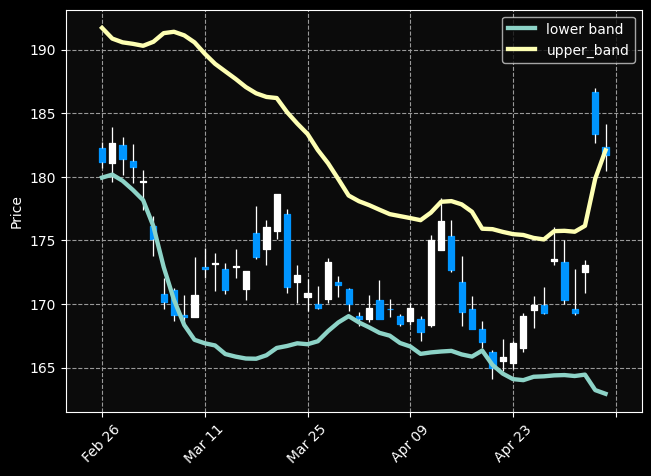

In [73]:
apd  = [mpf.make_addplot(df['lower_band'], label='lower band'),
        mpf.make_addplot(df['upper_band'], label='upper_band')]
mpf.plot(df,addplot=apd,type='candle',style='nightclouds')

In [74]:
def generate_bollinger_band_signals(df):
    """
    Generate buy and sell signals using Bollinger Bands trading rule.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial time series data.

    Returns:
        df (pd.DataFrame): DataFrame with additional columns for buy and sell signals.
    """
    df['signal_BB'] = 0
    for i in range(1, len(df)):
        if df['high'][i] > df['upper_band'][i] : # overbought
            df.loc[df.index[i], 'signal_BB'] = -1

        elif df['low'][i] < df['lower_band'][i]: #oversold
            df.loc[df.index[i], 'signal_BB'] = 1

        else:
            df.loc[df.index[i], 'signal_BB'] = 0
    return df



In [75]:
df =generate_bollinger_band_signals(df)

# Create new column based on 'trend'
df['adjusted_close_overbought_BB'] = df.apply(lambda row: row['high'] * 1.005 if row['signal_BB'] == -1 else np.nan, axis=1)
df['adjusted_close_oversold_BB'] = df.apply(lambda row: row['low'] * 0.995 if row['signal_BB'] == +1 else np.nan, axis=1)


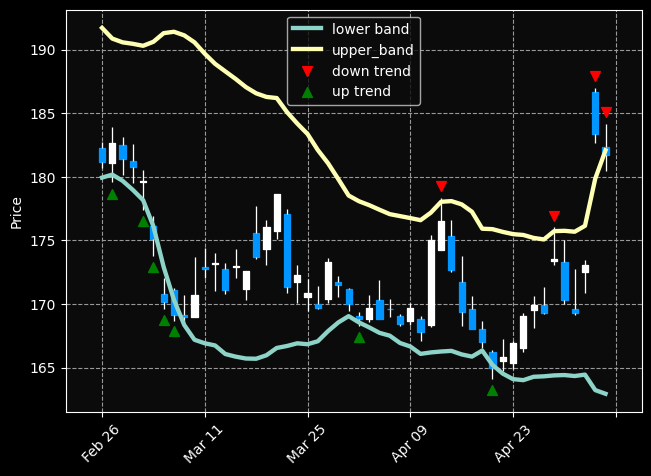

In [76]:
apd  = [mpf.make_addplot(df['lower_band'], label='lower band'),
        mpf.make_addplot(df['upper_band'], label='upper_band'),
        mpf.make_addplot(df['adjusted_close_overbought_BB'],type='scatter',markersize=50,marker='v',color='red', label='down trend'),
        mpf.make_addplot(df['adjusted_close_oversold_BB'],type='scatter',markersize=50,marker='^',color='green', label='up trend')]

mpf.plot(df,addplot=apd,type='candle',style='nightclouds')




### ***Feature Engineering***

In [77]:
df = encode_categorical_column(df, 'signal_BB')
df.head()

,open,high,low,close,volume,willr,rsi6,rsi12,ma5,ma6,...,adjusted_close_uptrend,trend1,trend2,trend3,signal_BB,adjusted_close_overbought_BB,adjusted_close_oversold_BB,signal_BB1,signal_BB2,signal_BB3
datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-26,182.24001,182.75999,180.64999,181.16,40867400,-88.38836,30.81671,36.10503,182.386,182.37333,...,NaN,0,1,0,0,NaN,NaN,0,1,0
2024-02-27,181.10001,183.92000,179.56000,182.63,54318900,-70.56563,43.02198,41.52139,182.600,182.42667,...,183.54315,0,0,1,1,NaN,178.6622,0,0,1
2024-02-28,182.50999,183.12000,180.13000,181.42,48953900,-79.58287,36.63753,38.58435,182.420,182.40334,...,NaN,1,0,0,0,NaN,NaN,0,1,0
2024-02-29,181.27000,182.57001,179.53000,180.75,136682600,-81.73653,33.34913,37.00327,181.696,182.14167,...,NaN,0,1,0,0,NaN,NaN,0,1,0
2024-03-01,179.55000,180.53000,177.38000,179.66,73488000,-72.02453,28.37685,34.49466,181.124,181.35667,...,NaN,0,1,0,1,NaN,176.4931,0,0,1


# 4.**Generating Turning Point**